In [1]:
import tensorflow as tf
import numpy as np
import keras_tuner as kt
import pandas as pd
import seq_generator
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
import json


pars = json.load(open("tuner_run/best_hps.json"))

train_ds , val_ds = seq_generator.get_train_and_val(batch_size=128)
img_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.15),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


inputs = tf.keras.Input([260,260,3])


x = tf.keras.layers.Resizing(224,224) (inputs)

x = img_augmentation(x)

base = tf.keras.applications.EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_tensor= x)

base.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base.output)

cnn = tf.keras.Model(inputs,x)

def build_model(hps):


    inputs = tf.keras.Input([5,260,260,3])
    x = layers.TimeDistributed(cnn)(inputs)

    drop1 = hps["drop1"]

    x = layers.TimeDistributed( layers.Dropout(drop1), name = "drop1") (x)

    hidden_units =  hps["hidden_units"]

    if hps["rnn"] == "lstm":
        x = layers.LSTM(hidden_units, name = "lstm")(x)
    else:
        x = layers.GRU(hidden_units, name = "gru") (x)

    drop2 = hps["drop2"]
    x = layers.Dropout(drop2,name ="drop2")(x)

    outputs = tf.keras.layers.Dense(2, activation="softmax", name="pred",kernel_regularizer=tf.keras.regularizers.L2())(x)

    learning_rate = hps["lr"]

    model = tf.keras.Model(inputs,outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = build_model(pars)


c:\Users\ual\.conda\envs\felix\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model.fit(train_ds, epochs=1, validation_data=val_ds)

283/283 [==============================] - 127s 408ms/step - loss: 0.1401 - accuracy: 0.9614 - val_loss: 0.2950 - val_accuracy: 0.8862


In [3]:
model.save_weights("tuner_run/new.ckpt")

In [4]:
cnn.trainable = True
for layer in cnn.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

for layer in cnn.layers[:-20]:

        layer.trainable = False

cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 img_augmentation (Sequential)  (None, 224, 224, 3)  0           ['resizing[0][0]']               
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['img_augmentation[0][0]']   

In [5]:
inputs = tf.keras.Input([5,260,260,3])
x = layers.TimeDistributed(cnn)(inputs)

drop1 = pars["drop1"]

x = layers.TimeDistributed( layers.Dropout(drop1), name = "drop1") (x)

hidden_units =  pars["hidden_units"]

if pars["rnn"] == "lstm":
    x = layers.LSTM(hidden_units, name = "lstm")(x)
else:
    x = layers.GRU(hidden_units, name = "gru") (x)

drop2 = pars["drop2"]
x = layers.Dropout(drop2,name ="drop2")(x)

outputs = tf.keras.layers.Dense(2, activation="softmax", name="pred",kernel_regularizer=tf.keras.regularizers.L2())(x)

learning_rate = pars["lr"]

model = tf.keras.Model(inputs,outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [6]:
model.load_weights("tuner_run/inet_frozen.ckpt")

In [7]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 260, 260, 3)]  0         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 1280)          4049571   
 tributed)                                                       
                                                                 
 drop1 (TimeDistributed)     (None, 5, 1280)           0         
                                                                 
 lstm (LSTM)                 (None, 192)               1131264   
                                                                 
 drop2 (Dropout)             (None, 192)               0         
                                                                 
 pred (Dense)                (None, 2)                 386       
                                                           

In [8]:
callbacks = []
callbacks.append(tf.keras.callbacks.ModelCheckpoint(
    monitor='val_accuracy',
    filepath=f"tuner_run/new2.ckpt",
    verbose=1,
    save_weights_only=True,
    save_best_only=True))

callbacks.append(tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    mode='auto'))

model.fit(train_ds, epochs=1, validation_data=val_ds,callbacks=callbacks)


283/283 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9837
Epoch 1: val_accuracy improved from -inf to 0.94020, saving model to tuner_run\new2.ckpt
283/283 [==============================] - 133s 440ms/step - loss: 0.0665 - accuracy: 0.9837 - val_loss: 0.1821 - val_accuracy: 0.9402


In [2]:
model.load_weights('tuner_run/frozen.ckpt')

In [5]:
labels = np.argmax(np.concatenate(list(ds.map(lambda x,y: y))),axis = 1)

In [3]:
df = pd.read_feather('new_train_seqs.df').set_index('index').query('ds_type == "train"')

In [4]:

func = lambda s: s[s.find("images/")+7:]
def mapping(img1,img2,img3,img4,img5,label):

    img1 = tf.io.decode_jpeg(tf.io.read_file(img1), channels=3)
    img2 = tf.io.decode_jpeg(tf.io.read_file(img2), channels=3)
    img3 = tf.io.decode_jpeg(tf.io.read_file(img3), channels=3)
    img4 = tf.io.decode_jpeg(tf.io.read_file(img4), channels=3)
    img5 = tf.io.decode_jpeg(tf.io.read_file(img5), channels=3)

    img_seq = tf.stack([img1,img2,img3,img4,img5])

    label = tf.one_hot(label,2)

    return img_seq, label


paths = np.array([[f"../seq_data/{s}/{func(i)}"for i in c] for c,s in zip(df.Paths,df.ds_type)]) 

labels = (df.view_direction == "Sideways").apply(int).values

ds = tf.data.Dataset.from_tensor_slices((paths[:,0],paths[:,1],paths[:,2],paths[:,3],paths[:,4],labels))
ds = ds.map(mapping)
ds = ds.batch(batch_size=64)
ds = ds.prefetch(tf.data.AUTOTUNE)

In [35]:
(labels == (val_df.view_direction == 'Sideways')).all()

False

In [6]:
df['labels'] = (df.view_direction == 'Sideways').astype(float)

In [7]:
model.evaluate(ds)

567/567 [==============================] - 107s 176ms/step - loss: 0.0951 - accuracy: 0.9636


[0.09510856121778488, 0.9636493921279907]

In [8]:
preds = model.predict(ds,verbose = 1)[:,1]

567/567 [==============================] - 99s 171ms/step


In [9]:
df['pred'] = preds

In [10]:
bce = tf.keras.losses.BinaryCrossentropy()
bce(df.labels,df.pred).numpy()

0.104954064

In [11]:
bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
df['loss'] = bce(df.labels.values[:,None],preds[:,None])

In [14]:
len(df) * 0.05

1812.9

In [15]:
(df.loss > 0.5).sum()

1548

In [16]:
df[(.5 < df.loss) ].sort_values('seq_key').reset_index().to_feather('imgl.df')

In [50]:
high_loss

In [68]:
val_df.sort_values("loss").reset_index().to_feather('imgl.df')

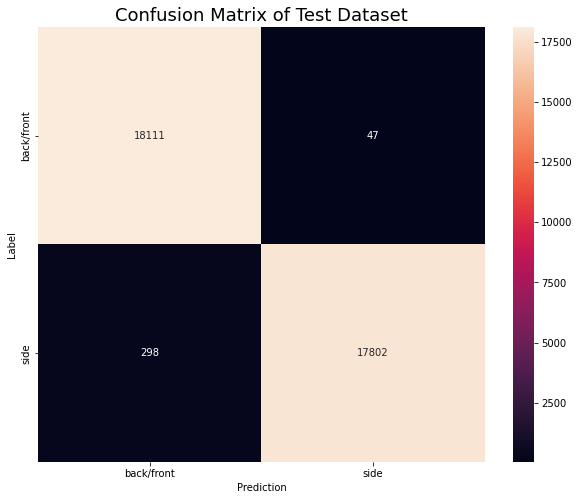

In [47]:
confusion_mtx = tf.math.confusion_matrix(df.labels,preds > 0.5)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

names = ["back/front","side"]

sns.heatmap(confusion_mtx, xticklabels=names, yticklabels=names, 
          annot=True, fmt='g')
plt.title("Confusion Matrix of Test Dataset",fontsize=18)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [12]:
import tensorflow as tf
import numpy as np
import keras_tuner as kt
import pandas as pd
import seq_generator
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
import tqdm
import matplotlib.pyplot as plt

In [16]:
val_df = pd.read_feather('imgl.df').set_index('index')
func = lambda s: s[s.find("images/")+7:]
val_df["local_path"] = np.array([[f"../seq_data/{s}/{func(i)}"for i in c] for c,s in zip(val_df.Paths,val_df.ds_type)]).tolist()

In [17]:
(val_df.loss > 2).sum()

197

In [20]:
val_df.columns

Index(['keys', 'frames', 'seq_key', 'cluster_id', 'view_direction',
       'City_Cluster', 'Paths', 'City', 'Flip', 'ds_type', 'og_cluster', 'ind',
       'pred', 'labels', 'loss', 'local_path'],
      dtype='object')

In [21]:
high_loss = val_df[(2 < val_df.loss) ].sort_values('seq_key')

for n in tqdm.tqdm(range(len(high_loss))):

    row = high_loss.iloc[n]
    fig, ax = plt.subplots(2,2,figsize=(12,12))
    keys = row['local_path']
    #np.random.shuffle(keys)
    for i,a in enumerate(ax.flatten()):
        try:
            a.imshow(plt.imread(keys[i]))
        except: pass
        a.axis('off')
    plt.suptitle(f"{row['view_direction']} {row['loss'] :.2f}")
    path = "tmp/new_train_val_df/" +  str(high_loss.index[n]) + ".jpg"
    plt.savefig(path)
    plt.close()

100%|██████████| 197/197 [01:06<00:00,  2.95it/s]


In [35]:
front = [int(i[:-4]) for i in os.listdir('tmp/front/')]
side = [int(i[:-4]) for i in os.listdir('tmp/side/')]
dels =  [int(i[:-4]) for i in os.listdir('tmp/del/')]


high_loss.loc[front].value_counts('view_direction')

view_direction
Forward     44
Sideways    42
dtype: int64

In [36]:
high_loss.loc[side].value_counts('view_direction')

view_direction
Sideways    105
dtype: int64

In [37]:
val_df.loc[front,'view_direction'] = 'Forward'
val_df.loc[side,'view_direction'] = 'Sideways'

In [41]:
si = pd.read_feather('new_train_imgs.df').set_index('key')
si.loc[np.unique(np.concatenate(val_df.loc[front,'keys'].values)),'view_direction'] = 'Forward'
si.loc[np.unique(np.concatenate(val_df.loc[side,'keys'].values)),'view_direction'] = 'Sideways'

In [42]:
val_df.drop(index=dels,inplace=True)

In [46]:
len(val_df) * 0.01

44.74

In [48]:
val_df.labels = (val_df.view_direction == 'Sideways')

In [49]:
(val_df.labels == (val_df.pred > 0.5)).mean()

0.9514975413500224

In [51]:
read_df = pd.read_feather('new_train_seqs.df').set_index("index")
read_df.loc[val_df.index] = val_df

In [53]:
read_df.columns

Index(['keys', 'frames', 'seq_key', 'cluster_id', 'view_direction',
       'City_Cluster', 'Paths', 'City', 'Flip', 'ds_type', 'og_cluster',
       'ind'],
      dtype='object')

In [54]:
read_df.loc[front].value_counts('view_direction')

view_direction
Forward    86
dtype: int64

In [55]:
read_df.reset_index().to_feather('new_train_seqs.df')
si.reset_index().to_feather('new_train_imgs.df')


In [ ]:
# seqs.loc[[int(i[:-4]) for i in os.listdir('tmp/front/')], 'view_direction'] = 'Forward'
# seqs.loc[[int(i[:-4]) for i in os.listdir('tmp/side/')], 'view_direction'] = 'Sideways'
# val_df.loc[np.unique(np.concatenate(seqs.loc[[int(i[:-4]) for i in os.listdir('tmp/front/')],"keys"].values)),"view_direction"] = "Forward"
# val_df.loc[np.unique(np.concatenate(seqs.loc[[int(i[:-4]) for i in os.listdir('tmp/side/')],"keys"].values)),"view_direction"] = "Sideways"

# val_df.drop(index = np.unique(np.concatenate(seqs.loc[[int(i[:-4]) for i in os.listdir('tmp/del/')],"keys"].values)),inplace=True)
# seqs.drop(index = [int(i[:-4]) for i in os.listdir('tmp/del/')], inplace= True)
# og_seqs = pd.read_feather('new_train_seqs.df').set_index('index')
# og_seqs.loc[og_seqs.ds_type == 'val'] = seqs
# og_seqs.reset_index().to_feather('new_train_seqs.df')
# df.loc[df.ds_type == 'val'] = val_df
# df.reset_index().to_feather("new_train_imgs.df")

In [4]:
model.load_weights("tuner_run/inet_frozen.ckpt")
preds = model.predict(train_ds,verbose=1)

283/283 [==============================] - 95s 335ms/step


In [5]:
preds.shape

(36224, 2)

In [6]:
train_df = pd.read_feather('new_train_seqs.df').set_index('index').query('ds_type == "train"').iloc[:len(preds)]


In [7]:
train_df['preds'] = preds[:,1]

In [8]:
bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
train_df['loss'] = bce((train_df.view_direction == 'Sideways').values.astype(float)[:,None],train_df.preds[:,None])

C:\Users\ual\AppData\Local\Temp\ipykernel_31660\785605206.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_df['loss'] = bce((train_df.view_direction == 'Sideways').values.astype(float)[:,None],train_df.preds[:,None])


In [10]:
(train_df.loss > 2).sum()

17641

In [11]:
hl = train_df.query('loss > 2')

In [14]:
hl.groupby('seq_key')['loss'].mean()

seq_key
-2Os-PQXDEyRhs6uPg08NA     3.591523
-2XfpmBJ74pyY3maS674UA    14.177850
-Klq_R1iTwy45_KcSbKF2g    13.121633
-Uw_oYlt3YZiDlsQIHVH8w     7.165172
-WhFPTNiCGD1ABtRuJxBAQ    13.738103
                            ...    
zpjzPg9ee_xaDHyy5iWF1A     9.830853
zs0KV70JsYHqJV6yIHRfug    10.223780
zt6fbpghjd3b3r53un91ke     9.081071
zuetq3q1nsyolpsid5rbfk     9.656166
zvFobTPGuRR8JZYyK5uW4Q    12.672115
Name: loss, Length: 960, dtype: float32

In [15]:
hl.reset_index().to_feather('imgl.df')